<a href="https://colab.research.google.com/github/lilyzhizhou/ML-Final-Project/blob/main/Naive_Bayes_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import plotly.express as px
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Pre-Diabetes Data
datapd = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #3/datapd.csv')

# Drop Patient_ID
datapd.drop('Patient_ID', axis = 1, inplace = True)
datapd.drop('Unnamed: 0', axis = 1, inplace = True)

print(datapd.shape)
datapd.head()

(6414, 11)


,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,1,63,30.9,NaN,0,1,0,1,0,1,1
1,1,66,23.6,3.54,1,1,1,0,0,1,1
2,0,68,34.3,5.55,1,1,1,0,0,1,0
3,1,73,28.5,3.78,1,1,0,1,1,1,0
4,0,53,33.4,5.38,0,1,1,0,1,1,0


In [ ]:
datapd.dtypes

predm                  int64
Age_at_Exam            int64
BMI                  float64
Total_Cholesterol    float64
Depression             int64
HTN                    int64
OA                     int64
COPD                   int64
corstrd_bin            int64
htnmed_bin             int64
Sex                    int64
dtype: object

In [ ]:
# Look for NA values
print(datapd.isnull().sum())

predm                  0
Age_at_Exam            0
BMI                    0
Total_Cholesterol    152
Depression             0
HTN                    0
OA                     0
COPD                   0
corstrd_bin            0
htnmed_bin             0
Sex                    0
dtype: int64


Separate data into continuous and categorical variables

---



In [4]:
target_column = 'predm'
categorical_columns = ['Depression', 'HTN','OA', 'COPD', 'Sex','corstrd_bin','htnmed_bin']
#multinomial_columns = [] there are none
numerical_columns = ['Age_at_Exam','BMI','Total_Cholesterol']

Split Data

---



In [5]:
# Splitting the original dataset into training, validation, and test sets

# Taking 70% of the data for training
train_df = datapd.sample(frac = 0.75)

# Removing the training data from the original dataset to get the combined validation and test data
test_df = datapd.drop(train_df.index)

# Splitting the combined validation and test data into two equal parts for validation and testing, respectively
valid_df = test_df.sample(frac = 0.5)
test_df = test_df.drop(valid_df.index)

In [6]:
# Impute Missing Values
imputer = SimpleImputer(strategy='median')
train_df[numerical_columns] = imputer.fit_transform(train_df[numerical_columns])
valid_df[numerical_columns] = imputer.fit_transform(valid_df[numerical_columns])
test_df[numerical_columns] = imputer.fit_transform(test_df[numerical_columns])

# Selected median bc it works well with skewed continuous data and is less sensitive to outliers and overfitting

In [7]:
# Normalize Data
scaler = StandardScaler()
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
valid_df[numerical_columns] = scaler.fit_transform(valid_df[numerical_columns])

In [8]:
# Convert continuous vars from float64 to int64
train_df[numerical_columns] = train_df[numerical_columns].astype('int64')
valid_df[numerical_columns] = valid_df[numerical_columns].astype('int64')

test_df = test_df.dropna() # drop na values
test_df[numerical_columns] = test_df[numerical_columns].astype('int64')

Fit Model

---



In [9]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, accuracy, recall, precision, fi
    conf_matrix = confusion_matrix(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)
    precision = precision_score(Y_pred, Y)
    recall = recall_score(Y_pred, Y)
    f1 = f1_score(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, auc, acc, precision, recall, f1, class_report

# Define a function to print the computed scores
def print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report):
    print("Confusion Matrix:")
    print(conf_matrix)
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("\nPrecision:")
    print(precision)
    print("\nRecall:")
    print(recall)
    print("\nf1-score:")
    print(f1)
    print("\nClassification Report:")
    print(class_report)

Confusion Matrix:
[[2053  809]
 [1032  916]]
AUC :  0.5937782053875967
Accuracy :  0.6172557172557173

Precision:
0.5310144927536232

Recall:
0.4702258726899384

f1-score:
0.4987748434522189

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2862
           1       0.53      0.47      0.50      1948

    accuracy                           0.62      4810
   macro avg       0.60      0.59      0.59      4810
weighted avg       0.61      0.62      0.61      4810



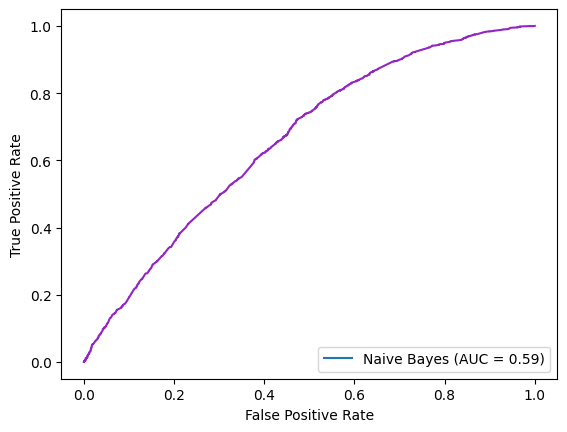

In [ ]:
# Train a Gaussian Naive Bayes model for numerical columns
gnb = GaussianNB()
gnb = gnb.fit(train_df[numerical_columns].to_numpy(), train_df[target_column])

# Train a Categorical Naive Bayes model for categorical columns
cnb = CategoricalNB(alpha = 1)
cnb = cnb.fit(train_df[categorical_columns].to_numpy(), train_df[target_column])

# Get joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(train_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(train_df[categorical_columns])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
# conf_matrix, class_report, auc, acc = get_scores(train_df[target_column], y_hat)
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(train_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(train_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Evaluating the Model on Validation Data

---



Confusion Matrix:
[[336 132]
 [162 172]]
AUC :  0.6164593889144786
Accuracy :  0.6334164588528678

Precision:
0.5657894736842105

Recall:
0.5149700598802395

f1-score:
0.5391849529780564

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.70       468
           1       0.57      0.51      0.54       334

    accuracy                           0.63       802
   macro avg       0.62      0.62      0.62       802
weighted avg       0.63      0.63      0.63       802



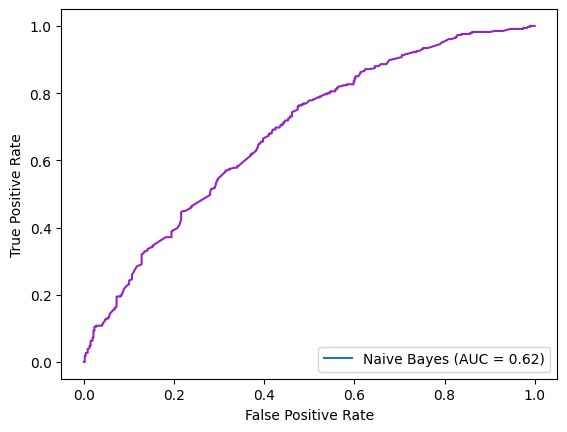

In [ ]:
# Predict the joint log probabilities for each model on validation data
gnb_log_pred = gnb.predict_joint_log_proba(valid_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(valid_df[categorical_columns])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels for validation data
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model on validation data using custom functions
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(valid_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plot the ROC curve for validation data
fpr, tpr, thresholds = roc_curve(valid_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Tune paramaters using gridsearch

---



In [33]:
# for categorical variables
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [i for i in range(0, 100)]}

grid_search = GridSearchCV(estimator=CategoricalNB(), param_grid=param_grid, cv=10)

grid_search.fit(train_df[categorical_columns].to_numpy(), train_df[target_column])

best_alpha = grid_search.best_params_['alpha']
print(best_alpha)

78


In [36]:
# for continuous variables
param_grid = {'var_smoothing': np.logspace(0,50,100)}

grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='roc_auc', return_train_score=True)

grid_search.fit(train_df[categorical_columns].to_numpy(), train_df[target_column])

# Extracting best parameter and its corresponding AUC score on training data
best_var_smoothing = grid_search.best_params_['var_smoothing']

print(best_var_smoothing)

3.1992671377973836


- Will not be including as accuracy decreased

Use new parameters for model

---



Confusion Matrix:
[[2139  703]
 [1149  819]]
AUC :  0.58439876160725
Accuracy :  0.614968814968815

Precision:
0.538107752956636

Recall:
0.41615853658536583

f1-score:
0.4693409742120344

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      2842
           1       0.54      0.42      0.47      1968

    accuracy                           0.61      4810
   macro avg       0.59      0.58      0.58      4810
weighted avg       0.60      0.61      0.60      4810



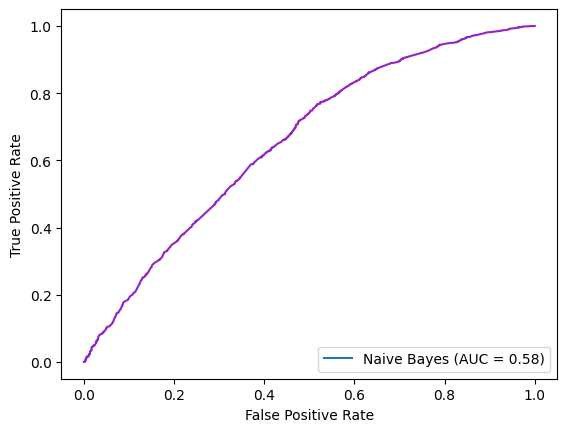

In [44]:
# Train a Gaussian Naive Bayes model for numerical columns
gnb = GaussianNB() #var_smoothing = best_var_smoothing)
gnb = gnb.fit(train_df[numerical_columns].to_numpy(), train_df[target_column])

# Train a Categorical Naive Bayes model for categorical columns
cnb = CategoricalNB(alpha = best_alpha)
cnb = cnb.fit(train_df[categorical_columns].to_numpy(), train_df[target_column])

# Get joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(train_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(train_df[categorical_columns])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(train_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(train_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Test on validation data

---



Confusion Matrix:
[[382 103]
 [175 142]]
AUC :  0.6177891963966308
Accuracy :  0.6533665835411472

Precision:
0.5795918367346938

Recall:
0.4479495268138801

f1-score:
0.505338078291815

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       485
           1       0.58      0.45      0.51       317

    accuracy                           0.65       802
   macro avg       0.63      0.62      0.62       802
weighted avg       0.64      0.65      0.64       802



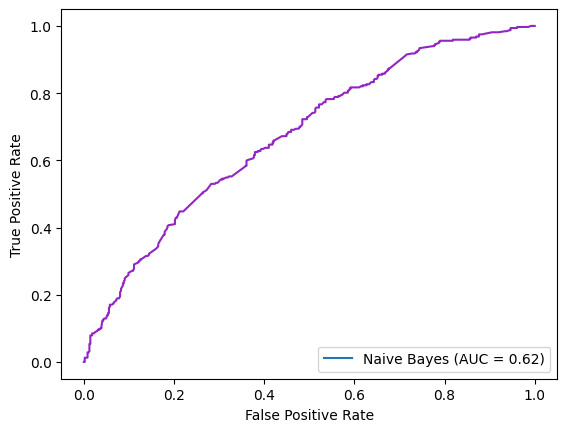

In [43]:
# Predict the joint log probabilities for each model on validation data
gnb_log_pred = gnb.predict_joint_log_proba(valid_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(valid_df[categorical_columns])

# Combine the log probabilities, adjusting for the multiplication of P(Y) term
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels for validation data
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model on validation data using custom functions
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(valid_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)


# Plot the ROC curve for validation data
fpr, tpr, thresholds = roc_curve(valid_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

- validation accuracy increased but training accuracy was lower after using best param

Final test with Test data

---



In [45]:
# Predict the joint log probabilities for each model on validation data
gnb_log_pred = gnb.predict_joint_log_proba(test_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(test_df[categorical_columns])

# Combine the log probabilities, adjusting for the multiplication of P(Y) term
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels for validation data
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model on validation data using custom functions
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(test_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)


# Plot the ROC curve for validation data
fpr, tpr, thresholds = roc_curve(test_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

Confusion Matrix:
[[471   0]
 [331   0]]
AUC :  0.5
Accuracy :  0.587281795511222

Precision:
0.0

Recall:
0.0

f1-score:
0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       471
           1       0.00      0.00      0.00       331

    accuracy                           0.59       802
   macro avg       0.29      0.50      0.37       802
weighted avg       0.34      0.59      0.43       802



ValueError: ignored

Confusion Matrix:
[[383  88]
 [199 132]]
AUC :  0.6059775113693947
Accuracy :  0.64214463840399

Precision:
0.6

Recall:
0.3987915407854985

f1-score:
0.4791288566243194

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       471
           1       0.60      0.40      0.48       331

    accuracy                           0.64       802
   macro avg       0.63      0.61      0.60       802
weighted avg       0.63      0.64      0.62       802



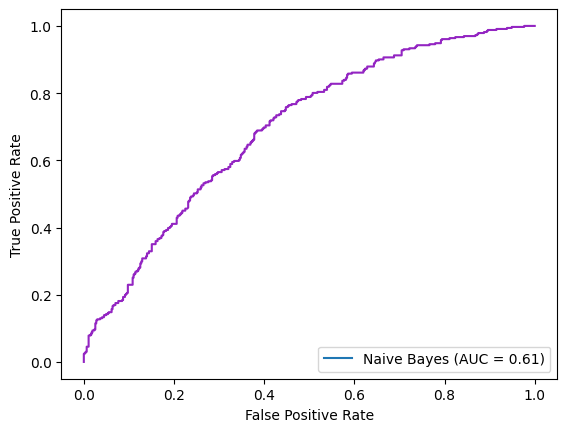

In [46]:
# Train a Gaussian Naive Bayes model for numerical columns
gnb = GaussianNB()
gnb = gnb.fit(test_df[numerical_columns].to_numpy(), test_df[target_column])

# Train a Categorical Naive Bayes model for categorical columns
cnb = CategoricalNB(alpha = best_alpha)
cnb = cnb.fit(test_df[categorical_columns].to_numpy(), test_df[target_column])

# Get joint log probabilities for each model
gnb_log_pred = gnb.predict_joint_log_proba(test_df[numerical_columns])
cnb_log_pred = cnb.predict_joint_log_proba(test_df[categorical_columns])

# Combine the log probabilities
y_hat_prob = gnb_log_pred + cnb_log_pred

# Convert log probabilities back to probabilities
y_hat_prob = np.exp(y_hat_prob)
y_hat_prob = y_hat_prob / y_hat_prob.sum(1, keepdims=True)  # normalize to get valid probabilities

# Get the predicted class labels
y_hat = np.argmax(y_hat_prob, axis=1)

# Evaluate the combined model using custom functions
conf_matrix, auc, acc, precision, recall, f1, class_report = get_scores(test_df[target_column], y_hat)
print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(test_df[target_column], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#9325c2')

- final accuracy 0.64